In [1]:
from fastai.vision.all import *
import fastai
import timm
import torch

import albumentations as A
transform = A.load("/media/newhd/OPTRetina/DMAE/autoalbument-amd/outputs/2021-11-24/10-32-22/policy/latest.json")

class AlbumentationsTransform(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [2]:
torch.cuda.set_device(2)

In [3]:
df = pd.read_csv('../trainValid.csv')

In [4]:
df

,Unnamed: 0,nombre_foto,grado de DMAE,binary,set
0,61504,anonymized_231059.jpg,normal,0,training
1,176989,anonymized_442122.jpg,normal,0,training
2,133399,anonymized_363034.jpg,normal,0,training
3,220150,anonymized_519072.jpg,normal,0,training
4,155853,anonymized_403989.jpg,normal,0,training
...,...,...,...,...,...
7797,224854,anonymized_528388.jpg,tardia,1,validation
7798,225492,anonymized_529721.jpg,intermedia,1,validation
7799,226322,anonymized_531350.jpg,precoz,1,validation
7800,227489,anonymized_533460.jpg,tardia,1,validation


In [5]:
def is_valid(path):
    name = path[1]
    return (df[df['nombre_foto']==name])['set'].values[0]=='validation'

# 384

In [6]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='beit_base_patch16_224_b',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [7]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384),AlbumentationsTransform(transform[0])], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [8]:
dls = db.dataloaders(df.values,bs=32,num_workers=0)

In [9]:
learn = Learner(dls,timm.create_model('beit_base_patch16_224',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

SuggestedLRs(valley=0.0003311311302240938)

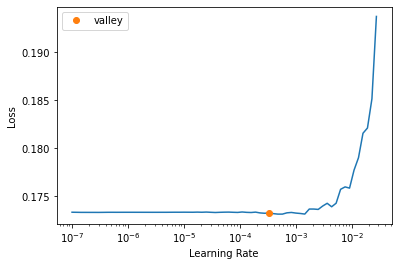

In [10]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.175877,0.174195,0.485897,0.492497,0.925641,0.642921,0.504892,02:20


Better model found at epoch 0 with f1_score value: 0.6429207479964382.


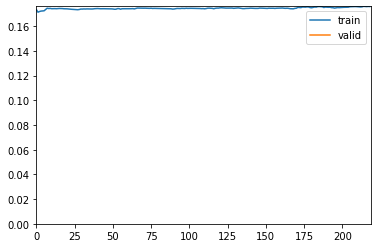

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.171178,0.175589,0.511538,0.506057,0.964103,0.663725,0.579589,02:22
1,0.169251,0.178269,0.523077,0.512295,0.961538,0.668449,0.611900,02:21
2,0.168559,0.172298,0.567949,0.544389,0.833333,0.658561,0.612988,02:22
3,0.168574,0.168798,0.567949,0.541213,0.892308,0.673766,0.649536,02:22
4,0.166561,0.173566,0.570513,0.542902,0.892308,0.675073,0.631368,02:22
5,0.168218,0.164645,0.620513,0.598739,0.730769,0.658199,0.657176,02:21
6,0.166058,0.171087,0.576923,0.546154,0.910256,0.682692,0.638642,02:22
7,0.166793,0.165491,0.602564,0.603093,0.600000,0.601542,0.646404,02:27
8,0.163458,0.164888,0.617949,0.597046,0.725641,0.655093,0.662216,02:26
9,0.163994,0.174821,0.592308,0.556782,0.905128,0.689453,0.643971,02:26


Better model found at epoch 0 with f1_score value: 0.6637246248896734.


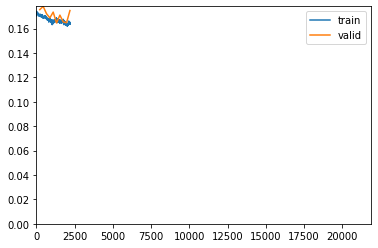

Better model found at epoch 1 with f1_score value: 0.6684491978609626.
Better model found at epoch 3 with f1_score value: 0.6737657308809294.
Better model found at epoch 4 with f1_score value: 0.6750727449078565.
Better model found at epoch 6 with f1_score value: 0.6826923076923077.
Better model found at epoch 9 with f1_score value: 0.689453125.
No improvement since epoch 5: early stopping


In [11]:
learn.fine_tune(100,base_lr=3e-3)

In [12]:
dfTest = pd.read_csv('../testSample.csv')

In [13]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [14]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [15]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=32,num_workers=0)

In [16]:
learn.dls = dlsTest

In [17]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.7128278763971072.


(#6) [0.16428996622562408,0.618461549282074,0.5783050847457627,0.8748717948717949,0.6963265306122449,0.7128278763971072]